In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from time import time
from sklearn import svm
from sklearn import cross_validation

import MHR as mhr

def simple_spearman(x,y): return np.abs(spearmanr(x,y)[0])
spearmanr_scorer = make_scorer(simple_spearman)

In [47]:
def reload_package(root_module):
    package_name = root_module.__name__

    # get a reference to each loaded module
    loaded_package_modules = dict([
        (key, value) for key, value in sys.modules.items() 
        if key.startswith(package_name) and isinstance(value, types.ModuleType)])

    # delete references to these loaded modules from sys.modules
    for key in loaded_package_modules:
        del sys.modules[key]

    # load each of the modules again; 
    # make old modules share state with new modules
    for key in loaded_package_modules:
        print 'loading %s' % key
        newmodule = __import__(key)
        oldmodule = loaded_package_modules[key]
        oldmodule.__dict__.clear()
        oldmodule.__dict__.update(newmodule.__dict__)
        
def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def calc_ndcg(df, column,k):
    min_votes=5
    min_comments=30

    ndcg_global=[]
    grouped=df.groupby('asin')

    for name, group in grouped:
        dffiltro = (df['asin']==name)
        
        values_test = df[dffiltro]['helpfulness'].T.to_dict().values()
        scores = df[dffiltro][column].T.to_dict().values()


        ind = (-np.array(scores)).argsort()
        a = np.array(values_test)[ind]	
        ndcg = ndcg_at_k(a, k)
        ndcg_global.append(ndcg)
    return ndcg_global

def calc_ndcg_mean(df, column,k):
    x = calc_ndcg(df,column,k)
    return np.mean(x)

def calc_corr(df, column):
    correlation=[]
    grouped=df.groupby('asin')

    for name, group in grouped:
        dffiltro = (df['asin']==name)
        
        helpfulness = df[dffiltro]['helpfulness'].T.to_dict().values()
        scores = df[dffiltro][column].T.to_dict().values()
        correlation.append(np.corrcoef(helpfulness,scores)[0][1])
    return correlation

In [3]:
reviews_features = pd.read_csv('data/eletronic_sample_counts.csv.gz')
reviews_features.shape

(19756, 19)

In [4]:
reviews_features.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'asin', u'helpful', u'overall',
       u'reviewText', u'reviewTime', u'reviewerID', u'reviewerName',
       u'summary', u'unixReviewTime', u'helpfulness', u'tot', u'word_count',
       u'sentence_count', u'unigram_count', u'pos_tag', u'adj', u'noun'],
      dtype='object')

In [5]:
df_columns = reviews_features.select_dtypes(include=['float64','int','int64']).columns
df_columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'overall', u'unixReviewTime',
       u'helpfulness', u'tot', u'word_count', u'sentence_count',
       u'unigram_count', u'adj', u'noun'],
      dtype='object')

In [19]:
#CROSVALIDATION BY PRODUCTION
clf = svm.SVR(epsilon=0.001)


products=[]
ndcg=[]
ind=0
bestSVMPrediction=pd.DataFrame()
max_ndcg=0
for name, group in reviews_features.groupby('asin'):
    products.append(name)
len(products)

rs = cross_validation.ShuffleSplit(len(products), n_iter=10, test_size=.1 , random_state=0)
for train_index, test_index in rs:
    dffilter_train = (reviews_features['asin'].isin(np.array(products)[train_index])) 
    dffilter_test = (reviews_features['asin'].isin(np.array(products)[test_index]))
    #train
    features_train = reviews_features[dffilter_train][list(['word_count','sentence_count','unigram_count','adj','noun'])].values
    labels_train = reviews_features[dffilter_train]["helpfulness"].values
    clf.fit(features_train, labels_train)
    
    #test
    features_test = reviews_features[dffilter_test][list(['word_count','sentence_count','unigram_count','adj','noun'])].values
    labels_test = reviews_features[dffilter_test]["helpfulness"].values
    x=clf.predict(features_test)
    
    dfTest= reviews_features[dffilter_test]
    dfTest['svm']=x
    local_ndcg = calc_ndcg_mean(dfTest,'svm',5)
    ndcg.append(local_ndcg)
    print "ndcg at fold "+str(ind)+" = "+ str(local_ndcg) 
    
    if (local_ndcg>max_ndcg):
        bestSVMPrediction=dfTest
    
    ind=ind+1
    

ndcg at fold 0 = 0.656641973247
ndcg at fold 1 = 0.69292352431
ndcg at fold 2 = 0.640305014261
ndcg at fold 3 = 0.666428558281
ndcg at fold 4 = 0.64911469342
ndcg at fold 5 = 0.679759350434
ndcg at fold 6 = 0.641161387768
ndcg at fold 7 = 0.665532452184
ndcg at fold 8 = 0.593408602443
ndcg at fold 9 = 0.671172961415


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
#CROSVALIDATION BY COMMENTS
clf = svm.SVR(epsilon=0.001)


rs = cross_validation.ShuffleSplit(len(reviews_features), n_iter=10, test_size=.2 , random_state=0)
ind=0
ndcg=[]
for train_index, test_index in rs:
    #train
    features_train = reviews_features.ix[train_index][list(['word_count','sentence_count','unigram_count','adj','noun'])].values
    labels_train = reviews_features.ix[train_index]["helpfulness"].values
    clf.fit(features_train, labels_train)
    
    #test
    features_test = reviews_features.ix[test_index][list(['word_count','sentence_count','unigram_count','adj','noun'])].values
    labels_test = reviews_features.ix[test_index]["helpfulness"].values
    x=clf.predict(features_test)
    
    dfTest= reviews_features.ix[test_index]
    dfTest['svm']=x
    local_ndcg = calc_ndcg(dfTest,'svm',5)
    ndcg.append(local_ndcg)
    print "ndcg at fold "+str(ind)+" = "+ str(local_ndcg)
    
    ind=ind+1


In [20]:
print "fold " + str(np.argmax(ndcg)) 
count=0
for train_index, test_index in rs:
    if (count==int(np.argmax(ndcg))):
        
        #df=reviews_features.ix[test_index]
        df=reviews_features[reviews_features['asin'].isin(np.array(products)[test_index])]
        
        print (len(df))
        x=mhr.executeFromDf(df)

    count=count+1

fold 1
1940


In [25]:
len(x)

1940

MHR ndcg=0.83868889994
SVM ndcg=0.701388057204
39
39


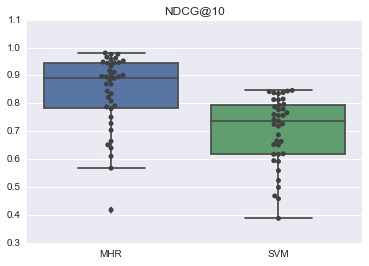

In [58]:
import seaborn as sns
k=10

ndcg_mhr=calc_ndcg(x,'powerWithStar',k) 
corr_mhr=calc_corr(x,'powerWithStar') 
print "MHR ndcg="+str(np.mean(ndcg_mhr))

ndcg_svm=calc_ndcg(bestSVMPrediction,'svm',k) 
corr_svm=calc_corr(bestSVMPrediction,'svm') 

print "SVM ndcg="+str(np.mean(ndcg_svm))

print (len(ndcg_svm))
print (len(ndcg_mhr))

tip={}
tip['SVM']=ndcg_svm
tip['MHR']=ndcg_mhr
df = pd.DataFrame(tip)
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, color=".25")
ax.set_title('NDCG@'+str(k))




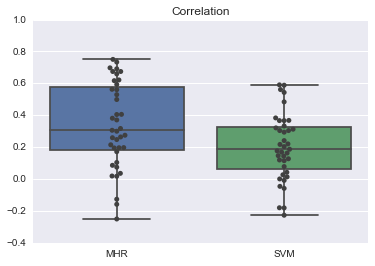

In [59]:
tip={}
tip['SVM']=corr_svm
tip['MHR']=corr_mhr
dftip=pd.DataFrame(tip)
#dftip.head()
ax = sns.boxplot(data=dftip)
ax = sns.swarmplot(data=dftip, color=".25")

ax.set_title('Correlation')